In [1]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

from utils import *
from torch_backend import Batches, Network, device
from torch import nn
import torchvision

### Network definitions

In [2]:
def batch_norm(num_channels, bn_bias_init=None, bn_bias_freeze=False, bn_weight_init=None, bn_weight_freeze=False):
    m = nn.BatchNorm2d(num_channels)
    if bn_bias_init is not None:
        m.bias.data.fill_(bn_bias_init)
    if bn_bias_freeze:
        m.bias.requires_grad = False
    if bn_weight_init is not None:
        m.weight.data.fill_(bn_weight_init)
    if bn_weight_freeze:
        m.weight.requires_grad = False
        
    return m

def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
    block['add'] =  (Add(), [(rel_path('conv3') if projection else rel_path('relu1')), rel_path('branch', 'conv2')])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):    
    if isinstance(c, int):
        c = [c, 2*c, 4*c, 4*c]
        
    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), [rel_path('in')]),
        'concat': (Concat(1), [rel_path('maxpool'), rel_path('avgpool')]),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}
    
    return {
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'classifier': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
            'output': Identity()
        })
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'classifier': {
            'pool': nn.MaxPool2d(4),
            'flatten': Flatten(),
            'linear': nn.Linear(channels['layer3'], 10, bias=False),
            'output': Mul(weight),
        }
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n


losses = {
    'loss':  (nn.CrossEntropyLoss(size_average=False), [('classifier','output'), ('target',)]),
    'correct': (Correct(), [('classifier','output'), ('target',)]),
}

### Training loop

In [3]:
def train(model, lr_schedule, train_set, test_set, batch_size=512, num_workers=0, weight_decay=5e-4, momentum=0.9):
    timer, table = Timer(), TableLogger()
    
    train_batches = Batches(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=num_workers)
    
    epochs = lr_schedule.knots[-1]
    opt_params = [(lr_schedule(x)/batch_size, weight_decay*batch_size, momentum) for 
                  x in np.arange(0, epochs, 1/len(train_batches))]
    optimizer = Nesterov(model.trainable_params(), params=opt_params)
    for epoch in range(1, epochs+1):
        epoch_stats = train_epoch(model, train_batches, test_batches, optimizer.step, timer, test_time_in_total=True)
        summary = union({'epoch': epoch, 'lr': lr_schedule(epoch)}, epoch_stats)
        table.append(summary)  
    return summary

### Download and preprocess data

In [4]:
DATA_DIR = './data'

train_set_raw = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True)
test_set_raw = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True)
t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(train_set_raw.train_data, 4))), train_set_raw.train_labels))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(test_set_raw.test_data)), test_set_raw.test_labels))
print(f'Finished in {t():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 2.5 seconds
Preprocessing test data
Finished in 0.095 seconds


### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - DAWNbench baseline + no initial bn-relu+ efficient dataloading/augmentation, 1 dataloader process (301s)

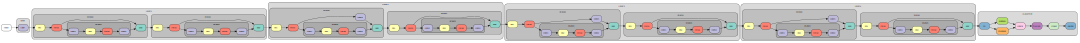

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0067       8.2791       1.6576       0.3862       0.4741       1.1689       0.5839       8.7533
           2       0.0133       8.2195       0.9838       0.6488       0.4669       0.8978       0.6926      17.4397
           3       0.0200       8.2099       0.7505       0.7380       0.4659       0.8151       0.7221      26.1155
           4       0.0267       8.2132       0.6305       0.7825       0.4655       0.6911       0.7635      34.7943
           5       0.0333       8.2136       0.5631       0.8069       0.4644       0.6404       0.7874      43.4723
           6       0.0400       8.2021       0.5105       0.8243       0.4652       0.5612       0.8046      52.1396
           7       0.0467       8.2036       0.4703       0.8377       0.4642       0.4831       0.8360      60.8074
           8       0.0533       8.2010       0.4377       0.8499

In [6]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size,  
              num_workers=1)

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - 0 dataloader processes (297s)

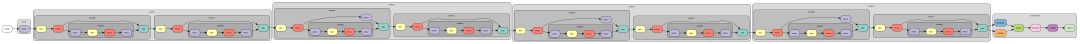

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0067       8.0188       1.6890       0.3726       0.4880       1.2267       0.5499       8.5068
           2       0.0133       8.0108       1.0115       0.6365       0.4879       0.9820       0.6606      17.0054
           3       0.0200       8.0138       0.7641       0.7310       0.4882       0.8996       0.7168      25.5074
           4       0.0267       8.0097       0.6415       0.7770       0.4896       0.6900       0.7646      34.0067
           5       0.0333       8.0139       0.5614       0.8056       0.4883       0.5932       0.8003      42.5089
           6       0.0400       8.0086       0.5133       0.8227       0.4878       0.6435       0.7797      51.0053
           7       0.0467       8.0073       0.4705       0.8374       0.4895       0.5561       0.8133      59.5022
           8       0.0533       8.0195       0.4398       0.8490

In [22]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size,  
              num_workers=0)

### [Post 2: Mini-batches](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_2/) - batch size=512 (256s)

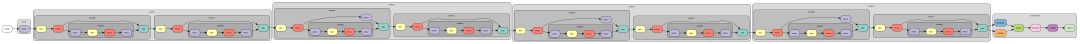

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0293       6.9102       1.7367       0.3520       0.4364       1.3308       0.5194       7.3466
           2       0.0587       6.9101       1.0568       0.6181       0.4375       1.3619       0.5442      14.6942
           3       0.0880       6.9035       0.7720       0.7290       0.4377       0.9958       0.6513      22.0354
           4       0.1173       6.9061       0.6302       0.7815       0.4418       0.8285       0.7298      29.3833
           5       0.1467       6.8933       0.5548       0.8076       0.4364       0.7106       0.7581      36.7130
           6       0.1760       6.8901       0.4937       0.8303       0.4366       0.5640       0.8067      44.0397
           7       0.2053       6.8906       0.4470       0.8469       0.4374       0.5474       0.8155      51.3676
           8       0.2347       6.9012       0.4207       0.8549

In [18]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - speed up batch norms (186s)

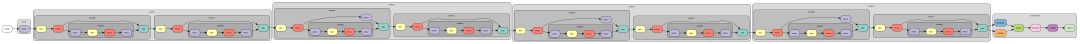

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0293       4.9656       1.7396       0.3542       0.3777       1.3201       0.5249       5.3433
           2       0.0587       4.9870       1.0842       0.6096       0.3787       1.1514       0.6079      10.7089
           3       0.0880       4.9628       0.7880       0.7197       0.3784       0.7102       0.7536      16.0501
           4       0.1173       4.9574       0.6383       0.7773       0.3784       0.9907       0.6792      21.3859
           5       0.1467       4.9560       0.5615       0.8045       0.3786       0.6710       0.7735      26.7205
           6       0.1760       4.9645       0.4945       0.8299       0.3782       0.6469       0.7775      32.0633
           7       0.2053       4.9619       0.4521       0.8438       0.3783       0.6008       0.7945      37.4035
           8       0.2347       4.9694       0.4227       0.8532

In [19]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - cutout+30 epochs+batch_size=512 (161s)

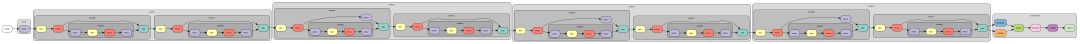

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0500       4.9998       1.7134       0.3621       0.3801       1.3864       0.5118       5.3800
           2       0.1000       4.9976       1.1146       0.5978       0.3817       1.1564       0.6094      10.7592
           3       0.1500       5.0167       0.8621       0.6960       0.3824       0.8509       0.7008      16.1582
           4       0.2000       5.0000       0.7150       0.7513       0.3816       0.9351       0.6791      21.5398
           5       0.2500       4.9926       0.6273       0.7819       0.3829       0.6840       0.7682      26.9152
           6       0.3000       4.9939       0.5680       0.8023       0.3810       0.7726       0.7420      32.2902
           7       0.3500       5.0036       0.5377       0.8132       0.3826       0.6129       0.7911      37.6764
           8       0.4000       4.9892       0.5180       0.8208

In [20]:
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.4, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/)  - batch_size=768 (154s)

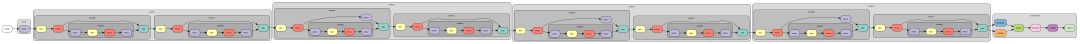

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0750       4.7665       1.8005       0.3312       0.3625       1.7933       0.3988       5.1291
           2       0.1500       4.7631       1.2164       0.5569       0.3616       1.3286       0.5605      10.2538
           3       0.2250       4.7781       0.9234       0.6717       0.3610       1.9069       0.4805      15.3929
           4       0.3000       4.7602       0.7563       0.7353       0.3608       1.2754       0.5916      20.5138
           5       0.3750       4.7607       0.6518       0.7719       0.3608       1.0105       0.6624      25.6353
           6       0.4500       4.7564       0.5858       0.7955       0.3633       0.8114       0.7108      30.7549
           7       0.5250       4.7547       0.5506       0.8092       0.3738       0.6870       0.7603      35.8835
           8       0.6000       4.7589       0.5307       0.8161

In [31]:
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.6, 0])
batch_size = 768

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size,
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone (36s; test acc 55.9%)

It seems reasonable to study how the shortest path through the network trains in isolation and to take steps to improve this before adding back the longer branches. 
Eliminating the long branches yields the following backbone network in which all convolutions, except for the initial one, have a stride of two.

Training the shortest path network for 20 epochs yields an unimpressive test accuracy of 55.9% in 36 seconds.

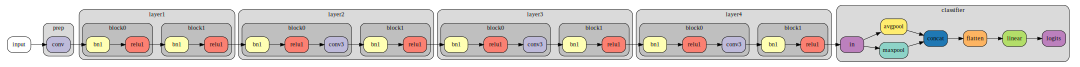

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       1.6292       1.9880       0.2645       0.1506       1.8361       0.3367       1.7799
           2       0.2000       1.6476       1.7583       0.3519       0.1518       1.7172       0.3726       3.5793
           3       0.3000       1.6193       1.6947       0.3821       0.1516       1.6560       0.4000       5.3502
           4       0.4000       1.6180       1.6714       0.3904       0.1516       1.6052       0.4240       7.1197
           5       0.3750       1.6172       1.6521       0.4000       0.1517       1.6319       0.4217       8.8887
           6       0.3500       1.6462       1.6171       0.4157       0.1516       1.5572       0.4402      10.6865
           7       0.3250       1.6130       1.5900       0.4244       0.1514       1.6200       0.4177      12.4509
           8       0.3000       1.6146       1.5741       0.4302

In [33]:
def shortcut_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
    return block

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block)
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, remove repeat bn-relu (32s; test acc 56.0%)

Removing the repeated batch norm-ReLU groups, reduces training time to 32s and leaves test accuracy approximately unchanged.

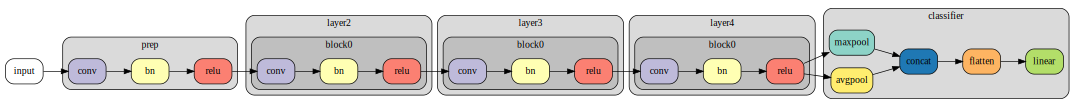

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       1.5423       1.9573       0.2828       0.1281       1.7754       0.3533       1.6704
           2       0.2000       1.4487       1.7521       0.3612       0.1292       1.7003       0.3846       3.2483
           3       0.3000       1.4360       1.6779       0.3880       0.1288       1.5929       0.4253       4.8131
           4       0.4000       1.4393       1.6603       0.3986       0.1296       1.6199       0.4212       6.3820
           5       0.3750       1.4742       1.6421       0.4057       0.1297       1.6115       0.4135       7.9858
           6       0.3500       1.4486       1.6048       0.4190       0.1297       1.5547       0.4371       9.5641
           7       0.3250       1.4411       1.5863       0.4274       0.1299       1.5215       0.4551      11.1352
           8       0.3000       1.5151       1.5565       0.4380

In [30]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv':  nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 3x3 convs (36s; test acc 85.6%)

A serious shortcoming of this network is that the downsampling convolutions have 1x1 kernels and a stride of two, so that rather than enlarging the receptive field they are simply discarding information. 

If we replace these with 3x3 convolutions, things improve considerably and test accuracy after 20 epochs is 85.6% in a time of 36s.

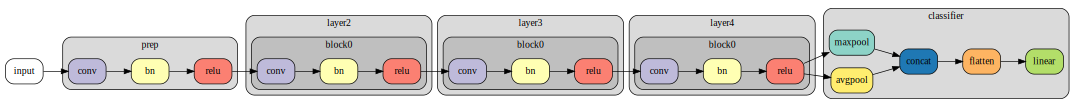

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       1.6322       1.7248       0.3647       0.1408       1.5693       0.4567       1.7730
           2       0.2000       1.6675       1.3276       0.5209       0.1424       1.0717       0.6214       3.5829
           3       0.3000       1.6341       1.1531       0.5886       0.1419       1.1736       0.5943       5.3590
           4       0.4000       1.6340       1.1121       0.6047       0.1423       1.0290       0.6370       7.1353
           5       0.3750       1.6349       1.0513       0.6268       0.1419       0.9427       0.6773       8.9121
           6       0.3500       1.6335       0.9528       0.6645       0.1682       0.8401       0.7071      10.7138
           7       0.3250       1.6349       0.9026       0.6818       0.1422       0.8340       0.7067      12.4908
           8       0.3000       1.6344       0.8292       0.7078

In [34]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, maxpool downsampling (43s; test acc 89.7%)

We can further improve the downsampling stages by applying 3x3 convolutions of stride one followed by a pooling layer instead of using strided convolutions. 

We choose max pooling with a 2x2 window size leading to a final test accuracy of 89.7% after 43s. Using average pooling gives a similar result but takes slightly longer.

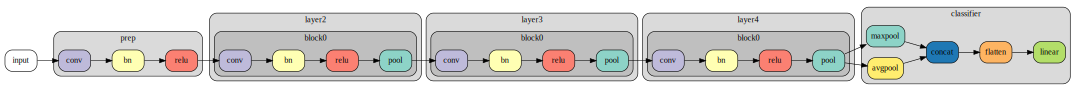

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       1.9707       1.7101       0.3900       0.1998       1.4375       0.5131       2.1705
           2       0.2000       1.9329       1.1738       0.5800       0.2007       1.1651       0.5969       4.3041
           3       0.3000       1.9317       0.9653       0.6669       0.2004       1.0034       0.6532       6.4362
           4       0.4000       1.9314       0.8947       0.6903       0.2007       0.8971       0.6891       8.5683
           5       0.3750       1.9553       0.8156       0.7175       0.2008       0.7270       0.7505      10.7245
           6       0.3500       1.9274       0.7242       0.7500       0.2013       0.9427       0.6910      12.8532
           7       0.3250       1.9269       0.6649       0.7692       0.2013       0.6975       0.7627      14.9813
           8       0.3000       1.9260       0.6276       0.7830

In [40]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size,
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 2x output dim, global maxpool (47s; test acc 90.7%)

The final pooling layer before the classifier is a concatenation of global average pooling and max pooling layers, inherited from the original network. 

We replace this with a more standard global max pooling layer and double the output dimension of the final convolution to compensate for the reduction in input dimension to the classifier, leading to a final test accuracy of 90.7% in 47s. Note that average pooling at this stage underperforms max pooling significantly.


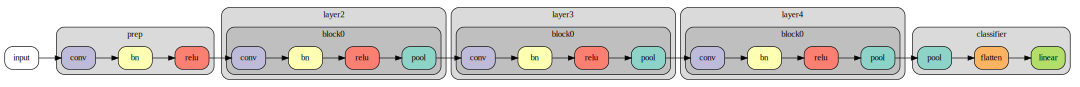

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.1131       1.8428       0.3667       0.2131       1.2734       0.5464       2.3262
           2       0.2000       2.1275       1.2441       0.5606       0.2145       0.9166       0.6694       4.6681
           3       0.3000       2.1292       0.9818       0.6596       0.2137       0.9394       0.6720       7.0110
           4       0.4000       2.1574       0.9087       0.6845       0.2141       0.8550       0.6882       9.3825
           5       0.3750       2.1303       0.8214       0.7193       0.2149       1.0545       0.6723      11.7277
           6       0.3500       2.1261       0.7063       0.7557       0.2144       0.5921       0.7935      14.0682
           7       0.3250       2.1274       0.6607       0.7703       0.2145       0.5672       0.8046      16.4101
           8       0.3000       2.1509       0.5984       0.7904

In [45]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(c=[64,128,256,512], block=shortcut_block, prep_bn_relu=True, concat_pool=False)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, bn scale init=1, classifier weight=0.125 (47s; test acc 91.1%)

By default in PyTorch (0.4), initial batch norm scales are chosen uniformly at random from the interval [0,1]. Channels which are initialised near zero could be wasted so we replace this with a constant initialisation at 1. 
This leads to a larger signal through the network and to compensate we introduce an overall constant multiplicative rescaling of the final classifier. A rough manual optimisation of this extra hyperparameter suggest that 0.125 is a reasonable value. 
(The low value makes predictions less certain and appears to ease optimisation.) 

With these changes in place, 20 epoch training reaches a test accuracy of 91.1% in 47s. 

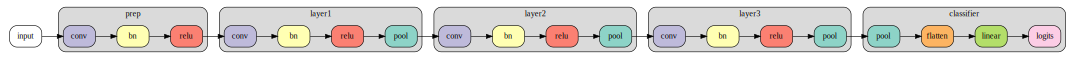

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.1115       1.8078       0.3572       0.2133       1.3768       0.4913       2.3248
           2       0.2000       2.1479       1.1368       0.6023       0.2145       1.1542       0.5801       4.6872
           3       0.3000       2.1135       0.8749       0.6991       0.2144       0.8167       0.7156       7.0151
           4       0.4000       2.1136       0.7513       0.7431       0.2144       0.6649       0.7738       9.3432
           5       0.3750       2.1150       0.6556       0.7767       0.2168       0.6872       0.7643      11.6749
           6       0.3500       2.1157       0.5767       0.8054       0.2430       0.6709       0.7692      14.0335
           7       0.3250       2.1155       0.5395       0.8186       0.2157       0.5782       0.7943      16.3647
           8       0.3000       2.1133       0.5022       0.8324

In [53]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net(extra_layers=(), res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - double width, 60 epoch train! (321s; test acc 93.5%)

ne approach that doesn't seem particularly promising is to just add width. 

If we double the channel dimensions and train for 60 epochs we can reach 93.5% test accuracy with a 5 layer network. This is nice but not efficient since training now takes 321s.

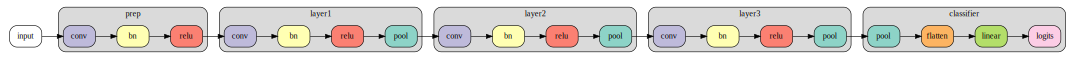

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       4.8971       1.8836       0.3421       0.4364       1.4763       0.4633       5.3335
           2       0.0667       4.9049       1.2386       0.5662       0.4371       0.9950       0.6476      10.6756
           3       0.1000       4.9083       0.9216       0.6834       0.4682       0.8560       0.6992      16.0521
           4       0.1333       4.9110       0.7603       0.7408       0.4383       0.6382       0.7826      21.4014
           5       0.1667       4.9154       0.6690       0.7732       0.4385       0.7536       0.7242      26.7554
           6       0.2000       4.9214       0.6102       0.7931       0.4396       0.6489       0.7799      32.1164
           7       0.2333       4.9206       0.5687       0.8076       0.4387       0.5926       0.7936      37.4758
           8       0.2667       4.9351       0.5306       0.8247

In [70]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
c = 128

n = net(channels={'prep': c, 'layer1': 2*c, 'layer2': 4*c, 'layer3': 8*c}, extra_layers=(), res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])
summary=train(model, lr_schedule, train_set_x, test_set, 
              batch_size=batch_size, 
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - extra:L1+L2+L3 network, 60 epochs, cutout=12 (180s, 95.0% test acc) 

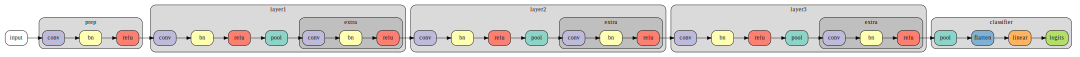

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       2.7303       1.8668       0.3338       0.2661       1.5857       0.4234       2.9965
           2       0.0667       2.7291       1.1783       0.5797       0.2665       1.0602       0.6222       5.9921
           3       0.1000       2.7620       0.8963       0.6849       0.2668       0.8000       0.7231       9.0209
           4       0.1333       2.7305       0.7668       0.7318       0.2674       1.0183       0.6687      12.0189
           5       0.1667       2.7307       0.6937       0.7568       0.2672       0.6089       0.7877      15.0167
           6       0.2000       2.7296       0.6332       0.7797       0.2674       0.7046       0.7556      18.0137
           7       0.2333       2.7587       0.5890       0.7941       0.2673       0.6949       0.7723      21.0397
           8       0.2667       2.7300       0.5624       0.8052

In [10]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
cutout=12

n = net(extra_layers=['layer1', 'layer2', 'layer3'], res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(cutout, cutout)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network Residual:L1+L3, 20 epochs (66s; test acc 93.7%)

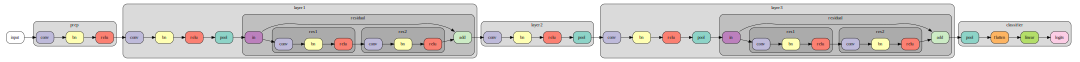

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       3.0038       1.6038       0.4141       0.2881       1.5042       0.5006       3.2919
           2       0.2000       3.0040       0.9377       0.6636       0.2887       1.3099       0.5947       6.5847
           3       0.3000       3.0044       0.7334       0.7446       0.2885       0.9623       0.6931       9.8776
           4       0.4000       3.0055       0.6242       0.7828       0.2893       0.7750       0.7265      13.1723
           5       0.3750       3.0318       0.5394       0.8128       0.2890       0.6397       0.7783      16.4930
           6       0.3500       3.0026       0.4714       0.8377       0.2889       0.5355       0.8194      19.7846
           7       0.3250       3.0019       0.4232       0.8559       0.2887       0.4263       0.8586      23.0753
           8       0.3000       3.0037       0.3982       0.8636

In [58]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network, 24 epochs (79s; test acc 94.1%)

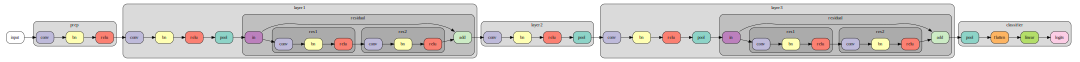

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800       3.0116       1.6176       0.4141       0.2890       1.2478       0.5766       3.3006
           2       0.1600       3.0112       0.9339       0.6684       0.2901       0.8335       0.7203       6.6019
           3       0.2400       3.0106       0.7138       0.7493       0.2895       0.7610       0.7422       9.9021
           4       0.3200       3.0109       0.6138       0.7861       0.2899       0.6544       0.7792      13.2028
           5       0.4000       3.0372       0.5535       0.8081       0.2896       0.7893       0.7374      16.5297
           6       0.3789       3.0092       0.4995       0.8280       0.2906       0.6219       0.7946      19.8295
           7       0.3579       3.0074       0.4435       0.8480       0.2904       0.6156       0.7870      23.1273
           8       0.3368       3.0045       0.4105       0.8581

In [62]:
lr_schedule = PiecewiseLinear([0, 5, 24], [0, 0.4, 0])
batch_size = 512

n = net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size)